# Time Series Point Extraction

Herein is an example of python code that extracts key points from a timeseries of the load applied to a medical device for testing purposes.  The code here shows exploration of a sample dataset and builds the functions for an automated approach.  A finalized/polished version of the functions created is utlized in industry to acquire information about the device performance.

In [310]:
import pandas as pd
import numpy as np
import glob

import matplotlib.pyplot as plt
from scipy.signal import argrelextrema


In [378]:
path = "/Users/Hailey/Documents/GitHub/projects/TimeSeriesPointExtraction/*.csv" 
for fname in glob.glob(path):
    print(fname)
    df = pd.read_csv(fname)

/Users/Hailey/Documents/GitHub/projects/TimeSeriesPointExtraction\AI-TS.csv


In [379]:
df.set_index('time', inplace = True)
data = df
#df.load = df.sub(df.load[0], axis = 'columns') #normalize initial load to 0.
df.head()

,load
time,
0.00,3.0
0.05,3.0
0.10,3.0
0.15,3.0
0.20,3.0


Below is a plot of the timeseries and the datapoints of interest for the plot.  The goal here is to repeatable identify these points in new data where there may be slight variations in the load or the time at which the load occurs. 

Text(0, 0.5, 'Load (lbf)')

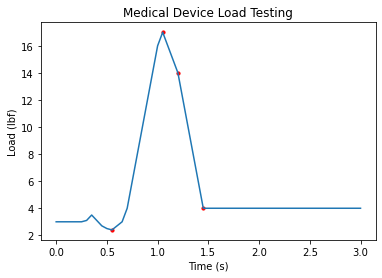

In [380]:
plt.plot(df.index, df.load)
y = [2.4, 17, 14, 4]
x = [0.55, 1.05, 1.2, 1.45]
plt.scatter(x,y,s=10,c='r', marker = 'o')
plt.title('Medical Device Load Testing')
plt.xlabel('Time (s)')
plt.ylabel('Load (lbf)')

Clearly, the peak value and the point of interest before the peak in the time series can be identified by finding the max and min values, respectively, of the time series. However, the point where the second derivitive is changing will indicate the final two points of interest.

The first derivative is calculated and plotted below.  This shows us the slope througout the plot.  In this plot we can also see when the slope is increasing or decreasing.

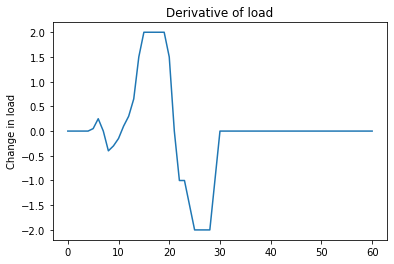

In [381]:
ddf = np.gradient(df.load)
plt.plot(ddf)
plt.title('Derivative of load')
plt.ylabel('Change in load')

df['deriv'] = ddf

Notice below when a plateau occurs, the values in the time series are changing at a constant rate.  This can be seen with the red points that occur leading up to the apex of the data and end prior to the apex (indicated by a red line) where we can visually see that the slope suddenly changes.  This can also be confimed by looking at the original data at the time frame between 0.90 and 1.05, which shows us that the load is changing by increments of 2 and then by an increment of 1.

In [382]:
df[0.90:1.05]

,load,deriv
time,,
0.90,12.0,2.0
0.95,14.0,2.0
1.00,16.0,1.5
1.05,17.0,0.0


Text(0.5, 0, 'Time (s)')

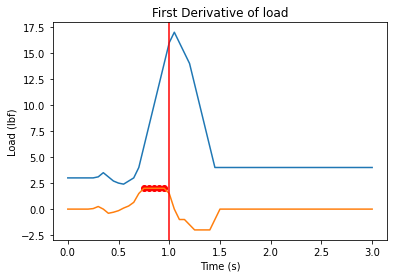

In [383]:
mx = max(df.deriv)
val_max = df[df['deriv']==mx].index.values
#print(mx, val_max)

plt.plot(df.index, df.load)
plt.plot(df.index, df.deriv)
for val in val_max:
    plt.scatter(val, 2.0, c='r')
    
plt.axvline(x=1.0, c='r')

plt.title('First Derivative of load')
plt.ylabel('Load (lbf)')
plt.xlabel('Time (s)')

Since the slope is decreasing at the third point of interest, finding the minima of the derivative will help us locate this point.  

To repeatably find the final point of interest, the second derivitive will be useful.  Below is a plot of the second derivative overlaid with vertical lines representing the locations of our points of interest.  Both the third and fourth points of interest occur at local minima/maxima of the second derivative of the load.  

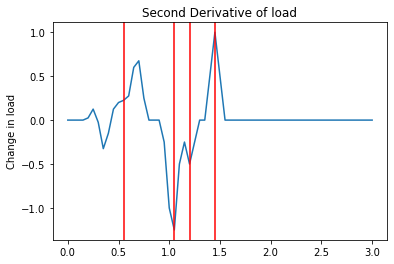

In [384]:
dddf = np.gradient(df.deriv)
#plt.plot(dddf)
plt.plot(df.index, dddf)
plt.title('Second Derivative of load')
plt.ylabel('Change in load')

df['secderiv'] = dddf

for val in x:
    plt.axvline(x=val, c='r')

1.0


Text(0, 0.5, 'Load (lbf)')

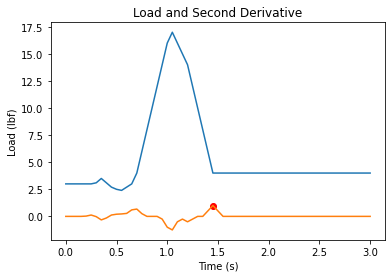

In [385]:
mx2 = max(df.secderiv)
print(mx2)
sec_val_max = df[df['secderiv']==mx2].index.values

plt.plot(df.index, df.load)
plt.plot(df.index, df.secderiv)
for val in sec_val_max:
    plt.scatter(val, 1, c='r')

plt.title('Load and Second Derivative')
plt.xlabel('Time (s)')
plt.ylabel('Load (lbf)')

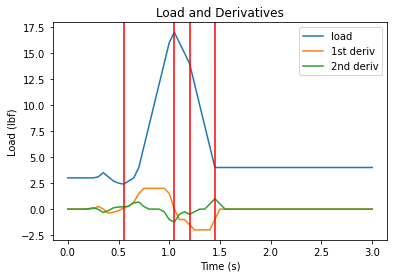

In [386]:
plt.plot(df.index, df.load)
plt.plot(df.index, df.deriv)
plt.plot(df.index, df.secderiv)
for val in x:
    plt.axvline(x=val, c='r')
    
plt.title('Load and Derivatives')
plt.xlabel('Time (s)')
plt.ylabel('Load (lbf)')
plt.legend(['load', '1st deriv', '2nd deriv'])

Methods for identifying each point of interest have been identified.  A function can now be created to identify each point repeatably.  

In [445]:
# get derivatives of original data
def get_derivs(data):
    ddf = np.gradient(data.load)
    data['deriv'] = ddf
    dddf = np.gradient(data.deriv)
    data['secderiv'] = dddf
    return data
    

# get key points from df, containing deriv columns.
def key_points(df, sampling_time):
    #create lists to store info.
    time = []
    load = []
    
    #id point 1
    time.append(df[df['load']==min(df.load)].index.values)
    load.append(min(df.load))
    #id point 2
    time.append(df[df['load']==max(df.load)].index.values)
    load.append(max(df.load))
    # id point 3
    time.append(df[df['deriv']==min(df.deriv)].index.values[0] - sampling_time)
    load.append(df.load[df[df['deriv']==min(df.deriv)].index.values[0] - smp_time])
    #id point 4
    time.append(df[df['secderiv']==max(df.secderiv)].index.values)  #df[df.secderiv == max(df.secderiv)].index.values
    load.append(df.load[df.secderiv == max(df.secderiv)].values)
    # return all the points
    points = pd.DataFrame(columns = ['time', 'load'])
    points['time'] = time
    points['load'] = load
    return points.astype(float)
    print(points.astype(float))

In [446]:
get_derivs(data) # we created the columns deriv and secderiv above while doing eda, but in order to automate, this function will do the same
key_points(data, 0.05) # finds our points of interest

,time,load
0,0.55,2.4
1,1.05,17.0
2,1.20,14.0
3,1.45,4.0
